In [1]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

In [2]:
def unif_mu(n: int, mu_min: float, mu_max: float, freq: float) -> torch.Tensor:
    """Generate n uniformly distributed mu's between mu_min and mu_max"""
    mu_annual = (mu_max - mu_min) * torch.rand(n) + mu_min
    mu_freq = mu_annual * freq
    return mu_freq

def toeplitz_cov(n: int, sigma_min: float, sigma_max: float, freq: float) -> torch.Tensor:
    """Generate a toeplitz covariance matrix with n elements and sigma_min and sigma_max"""
    sigmas_annual = (sigma_max - sigma_min) * torch.rand(n) + sigma_min
    sigmas_freq = sigmas_annual * np.sqrt(freq)
    cov = torch.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            rho = np.exp(-np.abs(i - j)/np.sqrt(n))
            cov[i,j] = rho * sigmas_freq[i] * sigmas_freq[j]
            cov[j,i] = cov[i,j]
    return cov

def generate_correlated_returns(n_points: int, mu: torch.Tensor, cov: torch.Tensor) -> torch.Tensor:
    """
    Generate n_vectors of correlated returns with mean mu and covariance cov
    """
    return torch.distributions.MultivariateNormal(mu, cov).sample((n_points,))


def generate_batch_correlated_returns(batch_size: int, n_vectors: int, mu: torch.Tensor, cov: torch.Tensor) -> torch.Tensor:
    """
    Generate n_vectors of correlated returns with mean mu and covariance cov
    """
    return torch.distributions.MultivariateNormal(mu, cov).sample((batch_size, n_vectors))


def rebuild_prices(returns: torch.Tensor, initial_price: float) -> torch.Tensor:
    """
    Rebuild prices from returns
    """
    n_points, n_assets = returns.shape
    prices = torch.zeros((n_points + 1, n_assets))
    prices[0] = initial_price
    for i in range(returns.shape[0]):
        prices[i+1] = prices[i] * (1 + returns[i])
    return prices

In [3]:
n_assets = 5 # number of assets we're trading
freq = 1/252 # daily data (so daily returns)

# we create synthetic data
mu_min, mu_max = 0.05, 0.3 # annual return
mu = unif_mu(n_assets, mu_min, mu_max, freq) # hourly return

sigma_min, sigma_max = 0.1, 0.3 # annual volatility
cov = toeplitz_cov(n_assets, sigma_min, sigma_max, freq) # hourly covariance

n_years = 1 # 1 year of data
n_points = int(n_years/freq) # number of points in the time series
returns = generate_correlated_returns(n_points, mu, cov)

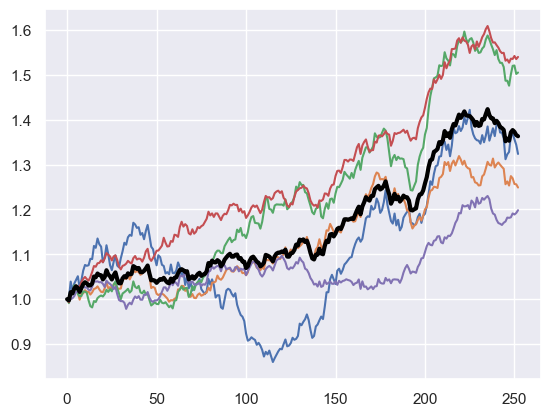

In [4]:
prices = rebuild_prices(returns, 1)
mean_price = torch.mean(prices, dim=1)
plt.plot(prices)
plt.plot(mean_price, color='black', linewidth=3)
plt.show()

## Markowitz Portfolio on this

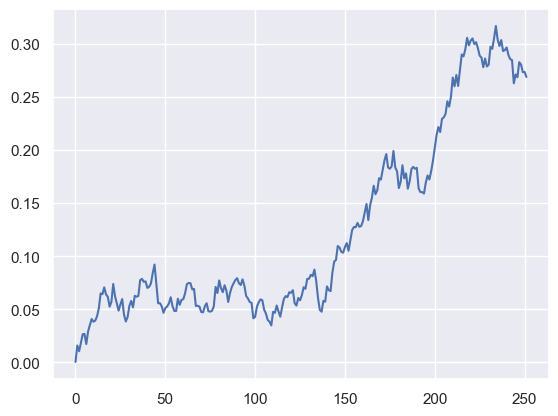

In [5]:
w = torch.inverse(cov) @ mu
w = w / torch.sum(w)

# compute returns of portfolio
portfolio_return = torch.zeros(n_points)
portfolio_pnl = torch.zeros(n_points)
for i in range(n_points):
    portfolio_return[i] = w @ returns[i, :]
    portfolio_pnl[i] = w @ (prices[i, :] * returns[i, :])

portfolio_value = torch.cumsum(portfolio_pnl, dim=0)
plt.plot(portfolio_value)
plt.show()

In [6]:
mean_daily_return = torch.mean(portfolio_return)
std_daily_return = torch.std(portfolio_return)
sharpe_ratio = mean_daily_return / std_daily_return * np.sqrt(1/freq)
print(f'Sharpe ratio: {sharpe_ratio:.2f}')

Sharpe ratio: 2.19


## Sig Trader of order 0 should yield Markowitz

In [7]:
batch_size = 100
initial_price = 100

batch_returns = generate_batch_correlated_returns(batch_size, n_points, mu, cov)

batch_prices = torch.zeros((batch_size, n_points + 1, n_assets))
for i in range(batch_size):
    batch_prices[i] = rebuild_prices(batch_returns[i], initial_price)

In [8]:
# Sig Trader parameters
depth = 0
delta = 1

# fit with only 100 samples
ts = trading_strategy.TradingStrategy(depth, delta)
info_data = torch.zeros((batch_size, n_points + 1, 0))

ts.fit(batch_prices, info_data)
ts.print_functionals()

ZZ_LL has length 157 but should have length 157
mu_sig successfully computed
all words of length <= 0 in alphabet of size 6 are ['']
m=0, n=0, w='', v=''
wf(m)="7", vf(n)="7"
words_shuffle=['77', '77']
accessing word "77" of length 2, given that E_ZZ_LL was computed at depth 2
accessing word "77" of length 2, given that E_ZZ_LL was computed at depth 2
m=0, n=1, w='', v=''
wf(m)="7", vf(n)="8"
words_shuffle=['78', '87']
accessing word "78" of length 2, given that E_ZZ_LL was computed at depth 2
accessing word "87" of length 2, given that E_ZZ_LL was computed at depth 2
m=0, n=2, w='', v=''
wf(m)="7", vf(n)="9"
words_shuffle=['79', '97']
accessing word "79" of length 2, given that E_ZZ_LL was computed at depth 2
accessing word "97" of length 2, given that E_ZZ_LL was computed at depth 2
m=0, n=3, w='', v=''
wf(m)="7", vf(n)="10"
words_shuffle=['710', '170', '107']
accessing word "710" of length 3, given that E_ZZ_LL was computed at depth 2


IndexError: index 1177 is out of bounds for dimension 0 with size 157

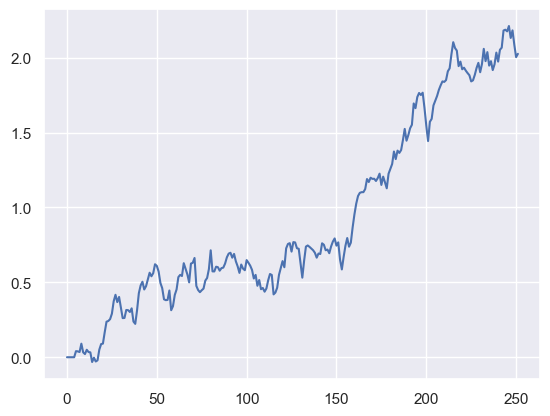

In [ ]:
# let's trade
index = 0
X = batch_prices[index]
f = info_data[index]
xi = ts.trade(X, f)
daily_pnl = ts.compute_pnl(X, xi) # daily pnl on each asset
daily_global_pnl = torch.sum(daily_pnl, dim=1) # daily pnl on the portfolio
cum_global_pnl = torch.cumsum(daily_global_pnl, dim=0)

plt.figure()
plt.plot(cum_global_pnl)
plt.show()

In [ ]:
example_path = batch_prices[0]
d = example_path.shape[1]
sig = utils.compute_signature(example_path, depth, no_batch=True)
len_sig = len(sig)
th_len_sig = utils.get_number_of_words_leq_k(depth, d)
print(len_sig, th_len_sig)

1 1
